# Next-Frame Video Prediction with Convolutional LSTMs

## Introduction

The
[Convolutional LSTM](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)
architectures bring together time series processing and computer vision by
introducing a convolutional recurrent cell in a LSTM layer.

## Setup for TPU

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


In [2]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.2.59.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.2.59.18:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.2.59.18:8470']
Number of accelerators:  8


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Dataset Construction

We are using [Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.

In [2]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:-4, 0 : data.shape[1] - 1, :, :]
    y = data[:-4, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (896, 19, 64, 64, 1), (896, 19, 64, 64, 1)
Validation Dataset Shapes: (96, 19, 64, 64, 1), (96, 19, 64, 64, 1)


## Data Visualization

Displaying frames for example 742.


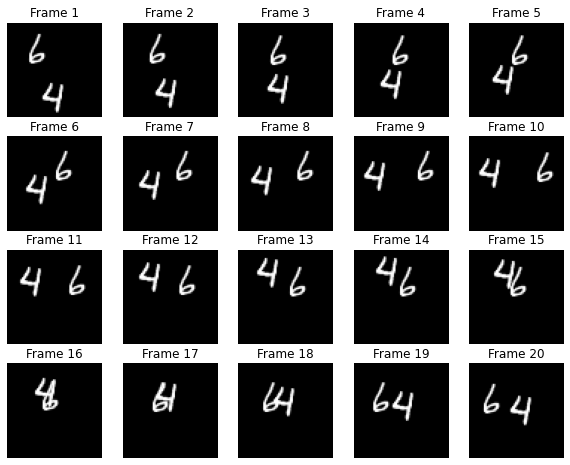

In [5]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction

In [42]:
def build_Model():
  # Construct the input layer with no definite frame size.
  inp = layers.Input(shape=(None, *x_train.shape[2:]))

  x = layers.ConvLSTM2D(
      filters=64,
      kernel_size=(5, 5),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(inp)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(.2)(x)
  x = layers.ConvLSTM2D(
      filters=64,
      kernel_size=(3, 3),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(.2)(x)
  x = layers.ConvLSTM2D(
      filters=64,
      kernel_size=(1, 1),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(x)
  x = layers.Conv3D(
      filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
  )(x)

  model = keras.models.Model(inp, x)

  return model

## Model Training

With our model and data constructed, we can now train the model.

In [92]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4)

# Define modifiable training hyperparameters.
epochs = 15
batch_size = 16


with strategy.scope():
    model = build_Model()
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam())
    model.summary()

        # Fit the model to the training data.
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        initial_epoch=0,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_lr],)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_27 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256   
                                                                 
 batch_normalization_18 (Bat  (None, None, 64, 64, 64)  256      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, None, 64, 64, 64)  0         
                                                                 
 conv_lstm2d_28 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168   
                                                                 
 batch_normalization_19 (Bat  (None, None, 64, 64, 64)  256

In [95]:
model.save('next_frame.h5')

## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

In [93]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]
new_frames=[]
# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    new_frames.append(new_prediction[-1,...])
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames[1:,...], predicted_frame), axis=0)

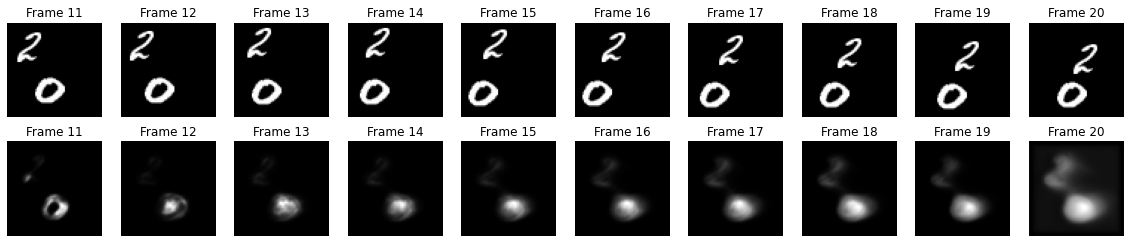

In [94]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
# new_frames = frames[10:, ...]
new_frames = new_prediction
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

# Visualization

In [3]:
from tensorflow.keras.models import load_model
base_model = load_model('next_frame.h5')

In [15]:
x = np.expand_dims(x_train[0], axis=0)
y = np.expand_dims(y_train[0], axis=0)

In [5]:
import tensorflow.compat.v1 as tf
import numpy as np
import keras
from keras import backend as K
from skimage import io
from skimage.transform import resize
# from scipy.misc import imread, imresize
from keras.layers.core import Lambda
from keras.models import Sequential
from keras.models import Model
from matplotlib import pyplot as plt
import os
# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()
import cv2

In [11]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [23]:
# build a new model with loss as output
def loss_layer(y_true, y_pred):
  bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
  return bce(y_true, y_pred)

Loss = Lambda(loss_layer)

class ComputeLoss(tf.keras.layers.Layer):
  def __init__(self):
      super(ComputeLoss, self).__init__()
  def call(self, inputs):
    y_true, y_pred = inputs
    return binary_crossentropy(y_true, y_pred)

In [7]:
from keras.layers.core import Lambda
from keras.models import Model
from keras import backend as K

def model_base():
  input = layers.Input(shape=(None, 64, 64,1))
  x = base_model(input)
  y = Lambda(lambda x: tf.reduce_sum(x,axis=(2,3,4)))(x)

  return Model(inputs=input,outputs=y)

In [26]:
base_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_27 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256   
                                                                 
 batch_normalization_18 (Bat  (None, None, 64, 64, 64)  256      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, None, 64, 64, 64)  0         
                                                                 
 conv_lstm2d_28 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168   
                                                                 
 batch_normalization_19 (Bat  (None, None, 64, 64, 64)  256

In [34]:
base_model.output.shape

TensorShape([None, None, 64, 64, 1])

In [37]:
conv_layer = base_model.layers[7]
conv_output = conv_layer.output
# loss = tf.reduce_sum(model.output, axis=(2,3))
heatmap_model = Model(base_model.inputs,outputs=[conv_output, base_model.output])

#### Capturing Gradients

In [52]:
model = model_base()
conv_layer = model.layers[1].layers[7]
conv_output = conv_layer.output
loss = model.output

x_ = tf.Variable(x)
with tf.GradientTape() as tape:
  activation_maps, out = heatmap_model(x)
  loss = tf.reduce_sum(out, axis=[2,3,4])
  grad = tape.gradient(loss, activation_maps)
# activation_maps = activation_maps[ 0 , :]

In [55]:
grad = normalize(grad)

In [56]:
activation_maps.shape, grad.shape

(TensorShape([1, 19, 64, 64, 64]), TensorShape([1, 19, 64, 64, 64]))

In [61]:
weights = np.maximum(grad,0)
weight_vector = np.sum(weights, axis=(2,3))

In [67]:
np.expand_dims(weight_vector, axis=(2,3)).shape

(1, 19, 1, 1, 64)

In [119]:
np.expand_dims(localization.max(axis=(2,3)), axis=(2,3)).shape

(1, 19, 1, 1)

#### Localization Logic

In [120]:
localization = np.sum(np.expand_dims(weight_vector, axis=(2,3))*activation_maps, axis=-1)
localization = np.maximum(localization,0)
localization = localization/np.expand_dims(localization.max(axis=(2,3)), axis=(2,3))
loc = np.squeeze(localization)

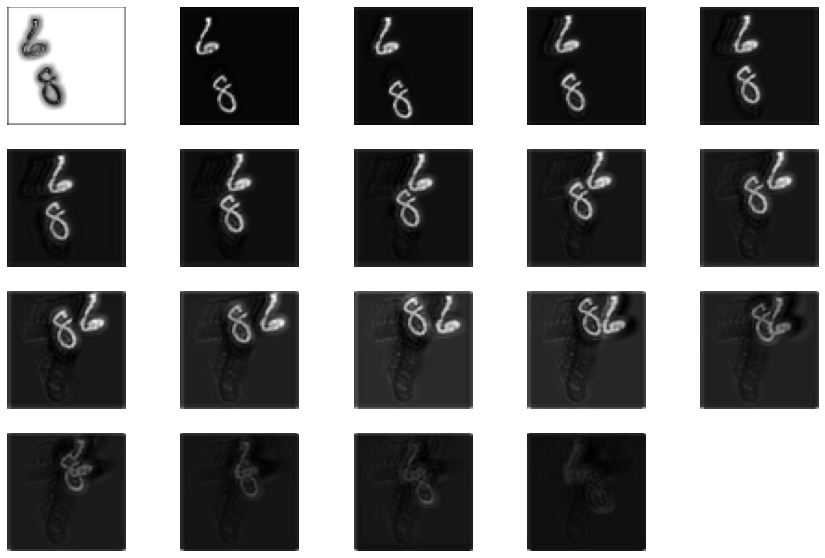

In [121]:
plt.figure(figsize=(15,10))
for i in range(loc.shape[0]):
  plt.subplot(4,5,i+1)
  plt.imshow(loc[i], cmap='gray')
  plt.axis('off')

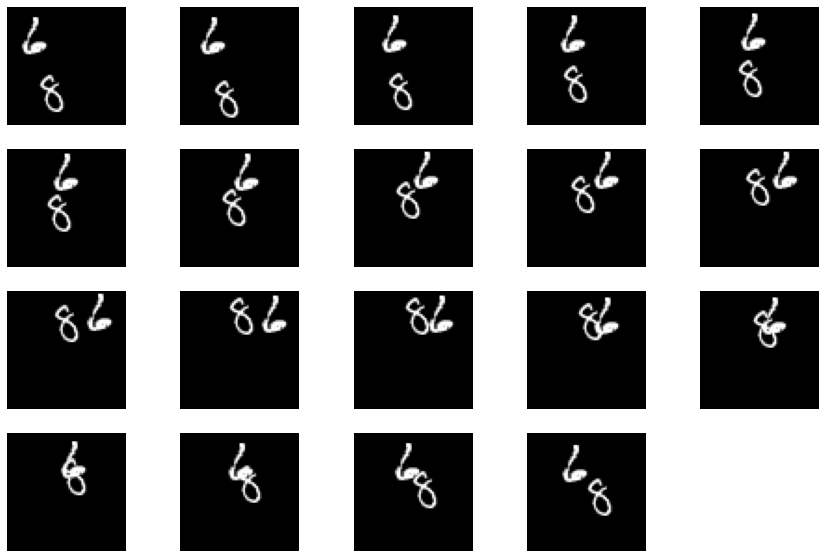

In [85]:
plt.figure(figsize=(15,10))
for i in range(y.shape[0]):
  plt.subplot(4,5,i+1)
  plt.imshow(y[i], cmap='gray')
  plt.axis('off')

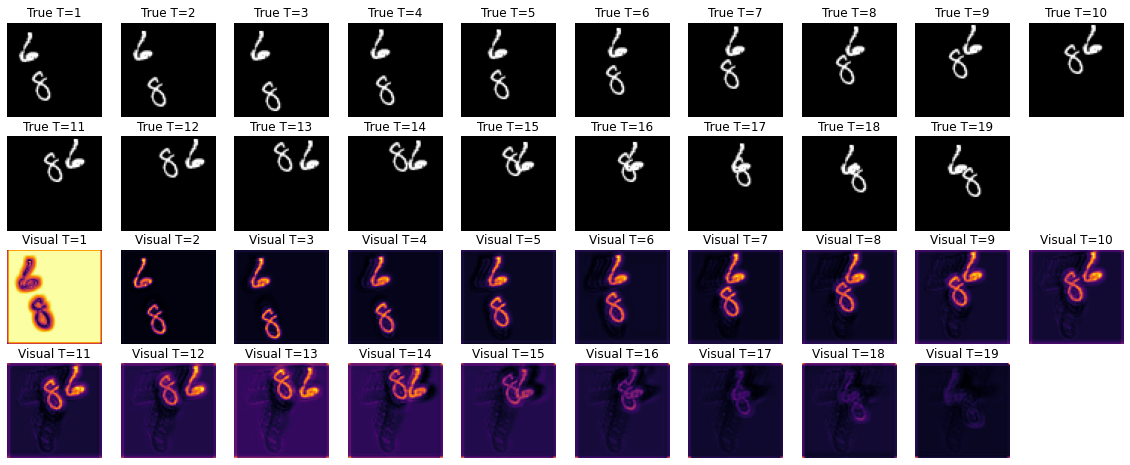

In [128]:
plt.figure(figsize=(20,8))
for i in range(19):
  plt.subplot(4,10,i+1)
  plt.imshow(x[i], cmap='gray')
  plt.title('True T='+str(i+1))
  plt.axis('off')
  
  plt.subplot(4,10,20+i+1)
  plt.imshow(loc[i], 'inferno')
  plt.axis('off')
  plt.title('Visual T='+str(i+1))

plt.savefig('lstm_viz.png')

(-0.5, 63.5, 63.5, -0.5)

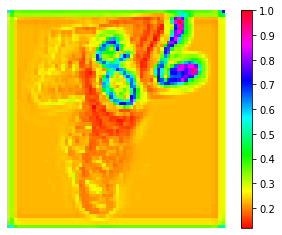

In [125]:
plt.imshow(loc[11],'hsv')
plt.colorbar()
plt.axis('off')

## GradCAM++ Visuals - Pending

In [ ]:
grads_val = grads_val[0 , :]

grads2 =  grads_val*grads_val
grads3  = grads_val*grads_val*grads_val

alpha_numerator = grads2
alpha_demonimator1 = 2*grads2

scale = np.sum( activation_maps , axis=( 0 , 1) )

alpha_demonimator2  = scale*grads3
alpha_demonimator2 = np.where(alpha_demonimator2 != 0.0, alpha_demonimator2, np.ones(alpha_demonimator2.shape))

alpha_demonimator =  alpha_demonimator2 + alpha_demonimator1
alpha = alpha_numerator/alpha_demonimator

weights1 = np.maximum(grads_val , 0 )

alphas_threshold_relu = np.where(weights1, alpha, 0.0)

alpha_normalized = np.sum(np.sum(alphas_threshold_relu, axis=0),axis=0)

alpha_normalized = np.where(alpha_normalized != 0.0, alpha_normalized, np.ones(alpha_normalized.shape))
alpha /= alpha_normalized.reshape((1,1,activation_maps.shape[2]))
deep_linearization_weights = np.sum((weights1*alpha).reshape((-1,activation_maps.shape[2])),axis=0)

dim = np.shape(activation_maps)[0]
localization_result = np.ones( (dim, dim) , dtype=np.float32 )

for i in range(len(deep_linearization_weights)):
    localization_result += deep_linearization_weights[i]*activation_maps[: , : , i]


localization_result = np.maximum (localization_result , 0 )
localization_result = localization_result / np.max(localization_result)
localization_result = resize(localization_result, (224,224))
cam3 = np.expand_dims(localization_result, axis=2)
cam3 = np.tile(cam3,[1,1,3])

img_eval_average_drop = img.astype(float)
img_eval_average_drop /= img_eval_average_drop.max()
img_eval_average_drop = img_eval_average_drop*cam3
img_eval_average_drop /= img_eval_average_drop.max()

img_eval_average_drop